In [0]:
# Don't run if not running in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Input data files are available in the "../mercari-price-suggestion-challenge/" directory.
**NOTE**: Please modify the absolute path before /mercari-price-suggestion-challenge accordingly

For example, running this (by clicking run or pressing Shift+Enter) will list the files in the mercari-price-suggestion-challenge directory

In [0]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pydot_ng as pydot

import gensim
import string
import re
from gensim.models import KeyedVectors

from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model, load_model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Conv1D, Flatten, MaxPooling1D
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.utils import plot_model
import keras
import keras.backend as K

# Input data files are available in the "../mercari-price-suggestion-challenge/" directory.
# NOTE: Please modify the absolute path before /mercari-price-suggestion-challenge accordingly

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the mercari-price-suggestion-challenge directory

import os
print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['sample_submission.csv.7z', 'sample_submission_stg2.csv', 'train.tsv', 'test.tsv', 'train.pkl', 'model.best.weights.hdf5', 'train_word2vec.pkl', 'model.png', 'train_xgboost.pkl', 'dumps', 'model_word2vec.best.weights.hdf5']


# 1. Load saved pickle and [skip till this cell](https://colab.research.google.com/drive/15-uCrPDef7kByQndWkC7JMH3-g3xOU_f?authuser=1#scrollTo=266Lf1n_6YMs)

In [0]:
data = pd.read_pickle(input_folder + 'dumps/whole_data_word2vec.pkl')

[Click here](https://colab.research.google.com/drive/15-uCrPDef7kByQndWkC7JMH3-g3xOU_f?authuser=1#scrollTo=266Lf1n_6YMs) to skip if you ran the above cell. **If not**, proceed to run normally and the program will compute the *whole_data_word2vec* pickle file

# 2. Data Preparation

In [0]:
# Load saved preprocessed train data and skip Data Preprocessing and Data Wrangling
train_ids = pd.read_pickle(input_folder + 'dumps/train_data.pkl')['train_id'].tolist()
val_ids = pd.read_pickle(input_folder + 'dumps/validation_data.pkl')['train_id'].tolist()
test_ids = pd.read_pickle(input_folder + 'dumps/test_data.pkl')['train_id'].tolist()
data = pd.read_pickle(input_folder + 'dumps/whole_data.pkl').drop(labels=['item_condition_id_1', 'item_condition_id_2', 'item_condition_id_3', 'item_condition_id_4', 'item_condition_id_5'], axis=1)

### Creating word embeddings  using word2vec



In [0]:
# Function to preprocess text for word2vec
def textPreProcessing(allText): 
    #remove newlines with space
    allText = allText.lower().replace("\n", " ")
    #remove punctuation
    allText = allText.translate({ord(c): None for c in string.punctuation})
    #remove multiple spaces
    allText = re.sub(" +", " ", allText)
    #tokenize
    tokens = allText.split(' ')
    return tokens

In [0]:
# train_data['name'] = train_data.name.str.translate({ord(c): ' ' for c in string.punctuation})
data['name'] = data.name.apply(lambda x: textPreProcessing(x))
data['item_description'] = data.item_description.apply(lambda x: textPreProcessing(x))

In [0]:
def word_embeddings(word2VecModel, allTextList, dim=100):
    word2Vec = word2VecModel.vocab.keys()
    wordVector = [np.zeros(dim)]
    for word in allTextList:
      if word in word2Vec:
        wordVector.append(word2VecModel[word][:dim])
    wordVector = np.mean(wordVector, axis=0)
    return wordVector

In [0]:
word2VecModel = gensim.models.KeyedVectors.load_word2vec_format(input_folder + 'wiki.en.bin.bin', binary = True )

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Convert & expand columns 'name' & 'item_description' to 100 dim word vectore for each columns. This results in 200 extra columns
data = pd.concat((data, data.apply(lambda x: word_embeddings(word2VecModel, x['name']), axis = 1, result_type='expand'), data.apply(lambda x: word_embeddings(word2VecModel, x['item_description']), axis = 1, result_type='expand')), axis=1)
del word2VecModel
data.to_pickle(input_folder + 'dumps/whole_data_word2vec.pkl')

<a id='restore_word2vec_data'></a>
Now, removing 'name' & 'item_description' from our data

In [0]:
data.drop(['name', 'item_description'], axis=1, inplace=True)

### Convert Categorical features into continuous features using Entity Embedding:  Embedding Preparation (Step 1)

### Sub-Feature Space

In [0]:
# rename duplicate columns of word2vec 
cols = pd.io.parsers.ParserBase({'names':data.columns})._maybe_dedup_names(data.columns)
data.columns = cols

In [0]:
data.head()

,train_id,item_condition_id,category_name,price,shipping,item_description_readability_score,desc_len,name_len,cat_1,cat_2,cat_3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,...,60.1,61.1,62.1,63.1,64.1,65.1,66.1,67.1,68.1,69.1,70.1,71.1,72.1,73.1,74.1,75.1,76.1,77.1,78.1,79.1,80.1,81.1,82.1,83.1,84.1,85.1,86.1,87.1,88.1,89.1,90.1,91.1,92.1,93.1,94.1,95.1,96.1,97.1,98.1,99.1
0,0,3,Men/Tops/T-shirts,-0.435170,1,99.00,1,7,Men,Tops,T-shirts,-0.047076,0.055123,0.096776,0.327872,-0.053400,-0.164231,0.123480,-0.097724,-0.025514,0.036671,0.278410,0.087304,-0.119336,0.021578,0.170031,-0.068347,-0.262792,0.085220,0.135382,0.257197,-0.033343,0.030893,-0.139916,-0.137116,0.101204,0.001052,-0.011945,-0.104977,-0.028738,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,3,Electronics/Computers & Tablets/Components & P...,0.656049,0,8.13,36,5,Electronics,Computers & Tablets,Components & Parts,-0.120774,0.074269,-0.030055,0.025553,-0.201962,-0.062714,0.062537,-0.079967,0.040506,-0.000242,-0.121404,-0.110225,-0.192543,0.092441,0.236934,-0.005942,0.196020,-0.008345,0.047493,0.249163,-0.034059,0.198465,-0.045585,-0.253211,-0.335730,-0.180222,-0.164575,0.075460,0.113512,...,0.003353,-0.038637,0.157240,-0.036119,-0.045491,-0.108587,-0.072237,0.012078,-0.098535,-0.013373,-0.030974,0.013579,0.136929,-0.073364,-0.120016,0.062757,0.126728,0.174966,0.015804,-0.064356,0.096281,0.051810,-0.082231,0.058357,-0.034755,-0.016786,0.001092,0.065343,-0.037469,-0.078727,0.023271,0.045434,0.218250,-0.214543,0.151894,-0.005827,0.050133,0.017548,-0.006065,0.026098
2,2,1,Women/Tops & Blouses/Blouse,-0.435170,1,5.80,29,3,Women,Tops & Blouses,Blouse,-0.006465,0.141957,-0.238290,0.147485,0.055197,0.094854,-0.036636,0.084593,0.201683,0.078710,0.044293,-0.031158,-0.118623,0.040195,0.145833,-0.082050,0.004320,-0.073832,0.243750,0.285230,0.056097,0.049053,-0.012986,0.044872,0.093857,0.025824,0.053050,0.129570,0.017823,...,-0.003588,-0.092107,0.160697,-0.082413,-0.039508,-0.140503,-0.165885,0.025680,-0.086208,0.045485,-0.145674,-0.069647,0.032995,-0.136541,-0.073738,-0.010755,0.111959,0.116104,-0.021502,0.002786,0.025296,-0.020523,-0.088607,-0.049129,-0.074163,-0.042309,-0.040612,0.000737,-0.017215,-0.093759,-0.038437,-0.044795,0.142766,-0.126110,0.110071,0.016851,0.059525,0.116074,-0.080349,0.021306
3,3,1,Home/Home Décor/Home Décor Accents,0.214365,1,2.12,32,3,Home,Home Décor,Home Décor Accents,0.040486,0.072910,-0.064110,0.221228,-0.012104,0.212159,-0.067450,-0.134002,0.118982,0.148352,0.106880,0.146617,0.014503,0.045757,0.174585,0.002362,-0.070346,0.041782,-0.009823,0.125930,0.006232,-0.130985,-0.276471,0.055807,0.003177,-0.086490,0.036153,-0.011490,0.081834,...,-0.055100,-0.103526,0.173241,-0.062109,0.028187,-0.071492,-0.145623,0.103997,-0.098056,-0.034283,-0.030356,0.036376,0.160841,-0.136764,-0.049553,0.040392,0.189657,0.155428,0.025785,-0.072665,0.114834,0.054884,-0.076146,-0.028510,-0.047560,-0.018541,-0.021588,0.053808,0.006598,-0.070150,0.029136,-0.057160,0.148940,-0.159945,0.097450,0.151162,0.020571,-0.019095,-0.086801,0.045617
4,4,1,Women/Jewelry/Necklaces,0.448198,0,18.00,5,4,Women,Jewelry,Necklaces,0.112307,0.004079,-0.044416,0.120497,-0.011662,0.185782,0.026220,-0.208632,0.140207,0.068560,0.238925,0.084456,0.058310,-0.058165,0.189186,-0.193500,-0.243460,-0.195550,-0.266418,0.109663,0.006964,-0.048250,-0.108760,0.087225,-0.212959,-0.034300,0.039582,0.084704,0.114839,...,-0.073604,-0.096410,0.099351,-0.043521,-0.047153,-0.090752,-0.106993,0.039182,-0.105936,-0.084915,-0.081389,-0.009586,0.087161,-0.088486,0.013255,-0.058588,0.253675,0.121763,0.009180,-0.043005,0.204753,0.033616,-0.061259,-0.168861,-0.098418,-0.011999,0

In [0]:
train_data = data.loc[train_ids]
val_data = data.loc[val_ids]
test_data = data.loc[test_ids]

In [0]:
target = ['price']

features = data.columns.tolist()
features.remove(target[0])
features.remove('train_id')
features.remove('category_name')
features.remove('name_len')
features.remove('desc_len')

embed_cols = ['cat_1', 'cat_2', 'cat_3', 'item_condition_id']
contin_vars = features.copy()
for feat in embed_cols:
  contin_vars.remove(feat)

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = train_data[features], train_data[target], val_data[features], val_data[target], test_data[features], test_data[target]

In [0]:
X_val.head()

,item_condition_id,shipping,item_description_readability_score,cat_1,cat_2,cat_3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,60.1,61.1,62.1,63.1,64.1,65.1,66.1,67.1,68.1,69.1,70.1,71.1,72.1,73.1,74.1,75.1,76.1,77.1,78.1,79.1,80.1,81.1,82.1,83.1,84.1,85.1,86.1,87.1,88.1,89.1,90.1,91.1,92.1,93.1,94.1,95.1,96.1,97.1,98.1,99.1
1365791,3,0,4.00,Beauty,Fragrance,Women,-0.012190,0.029873,-0.240805,0.198942,-0.100929,-0.035169,-0.015586,-0.027224,-0.007503,0.270154,0.051441,-0.042243,0.178979,-0.011001,-0.025115,-0.178549,-0.112389,-0.080231,-0.061040,0.201338,-0.082679,0.153556,-0.232386,-0.220772,-0.093753,-0.017486,-0.054351,-0.124890,0.066865,0.181532,-0.024232,0.282230,-0.114021,0.122455,...,-0.067474,-0.047046,0.133540,-0.046317,-0.104770,-0.165336,-0.093953,0.015939,0.069700,0.060737,-0.092608,0.097383,0.039260,-0.126100,-0.108281,0.132013,0.147092,0.157484,-0.076523,-0.001736,0.014080,-0.001209,-0.042704,-0.071986,-0.007445,0.029889,0.006454,0.065194,0.019889,-0.019623,0.030608,0.029440,0.123867,-0.188649,0.130663,0.084876,0.111980,0.117493,-0.094717,0.083751
986670,1,1,9.29,Beauty,Tools & Accessories,Makeup Brushes & Tools,0.064924,0.100857,-0.177311,0.222203,-0.055053,-0.097597,0.078476,-0.084850,0.107998,0.159537,0.098485,0.075785,0.021189,0.051966,0.096036,-0.245698,-0.206459,-0.098937,-0.032707,0.222372,-0.153566,-0.043081,-0.131456,-0.111103,-0.081334,-0.111455,0.037815,0.040076,0.121637,0.013383,-0.113488,0.094832,-0.099189,0.182174,...,-0.043322,-0.050127,0.146413,-0.066345,0.032073,-0.097000,-0.138161,0.033366,-0.047446,0.026055,-0.101641,0.033396,0.032060,-0.095924,-0.094244,0.040442,0.174707,0.138396,0.016974,-0.031742,0.053740,0.071648,-0.053110,-0.040805,-0.089486,0.014546,-0.008924,0.080460,-0.018821,-0.064583,0.037078,-0.016789,0.227826,-0.188903,0.101062,0.059297,0.020905,0.020958,-0.061580,0.016407
651498,3,0,0.80,Women,Tops & Blouses,T-Shirts,-0.050139,0.085613,0.009561,0.074084,0.000826,0.170170,0.069811,0.060261,0.022933,-0.039378,0.169179,0.086883,-0.132656,-0.030997,-0.019939,-0.086942,0.044034,0.028354,0.061850,0.139474,-0.048270,0.084365,-0.000242,-0.051999,0.229487,-0.127276,-0.135697,-0.034684,0.043894,0.070231,0.031445,0.146981,-0.009615,-0.054560,...,-0.020236,-0.173833,0.164927,-0.029310,-0.106280,-0.104965,-0.048157,-0.083455,-0.086498,0.104310,0.063494,-0.011256,-0.115367,-0.069666,0.027439,-0.081740,0.198063,0.158500,0.036404,0.102568,0.166170,0.016854,0.058331,0.009282,0.001924,-0.046797,0.033320,-0.128883,0.069148,-0.129010,-0.023203,0.214427,0.198050,-0.187947,0.154407,0.106637,-0.016431,-0.056499,-0.058958,-0.025788
107499,1,1,8.20,Electronics,Cell Phones & Accessories,Cables & Adapters,-0.068943,0.154125,0.067599,-0.091210,0.085836,0.085842,0.025464,0.079881,0.019828,0.112787,0.132463,-0.077508,0.093937,0.059388,0.125673,-0.034645,0.111879,0.075468,0.144868,0.074442,-0.202212,0.030239,-0.138610,-0.264715,-0.192195,-0.140730,-0.034809,-0.066247,0.054475,0.036618,-0.128621,0.186472,-0.124602,0.160424,...,0.055676,0.015008,0.005646,-0.015713,0.025200,-0.151504,-0.012315,-0.081559,-0.186804,-0.043387,0.050397,0.134087,0.248749,-0.119213,-0.089777,0.117574,0.106202,0.121184,-0.041585,-0.110279,0.067597,0.084913,0.034701,-0.120192,-0.093992,-0.101698,0.075702,0.157492,0.092456,0.062870,-0.032619,-0.051356,0.127510,0.025421,0.100677,0.027878,-0.118652,-0.045458,0.036423,0.011246
380562,1,1,3.60,Beauty,Makeup,Face,-0.042173,0.064546,-0.080930,0.173368,-0.184879,0.071995,0.120838,0.167566,0.057058,0.098058,0.383890,-0.008603,-0.024244,-0.081049,-0.110556,-0.053211,0.087859,-0.134017,0.025501,0.258850,-0.029576,0.195395,0.027596,-0.047979,-0.045614,-0.165561,-0.078852,0.013541,0.023611,0.085217,0.021601,0.263731,-0.131372,-0.021078,...,-0.035426,0.074640,0.217703,-0.116637,-0.024329,0.014202,-0.129988,0.066009,-0.128031,-0.068399,-0.096803,-0.036968,-0.014862,-0.125123,-0.009954,-0.093841,0.141546,-0.051876,-0.102803,-0.039546,-0.007021,-0.003102,-0

In [0]:
y_train.head()

,price
958469,-0.305263
693778,-0.227319
210050,-0.045449
447294,-0.071430
1480041,-0.357226


### Categorical Features To List Format

we need to convert data to list format to match the NN network structure.

The following function takes the list of categorical features, and prepare such lists for the NN input.

In [0]:
# Ref: https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb

embed_val_map = {}
for c in embed_cols:
        raw_vals = np.unique(train_data[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i
        embed_val_map[c] = val_map

def preproc_generator(X, embed_val_map):
    input_list = []
    unk_in_embed = {'cat_1': 'unk_cat1', 'cat_2': 'unk_cat2', 'cat_3': 'unk_cat3', 'item_condition_id': 1}
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        val_map = embed_val_map[c]
        input_list.append(X[c].map(val_map).fillna(val_map[unk_in_embed[c]]).values)
     
    #the rest of the columns
    other_cols = [c for c in X.columns if (not c in embed_cols)]
    input_list.append(X[other_cols].values)
    
    return input_list

### Embedding Dimension - Hyperparamter 

The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and reseach. 

##### One rule of thumb is to choose half of the cardinality of the categorical feature if that is is up to 50 in length.

In [0]:
for categorical_var in embed_cols:
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = train_data[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorical Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorical Variable: cat_1 Unique Categories: 11 Embedding Size: 6
Categorical Variable: cat_2 Unique Categories: 114 Embedding Size: 50
Categorical Variable: cat_3 Unique Categories: 871 Embedding Size: 50
Categorical Variable: item_condition_id Unique Categories: 5 Embedding Size: 3


#### Proper Naming of Categorical Features for Labelling NN Layers

In [0]:
for categorical_var in embed_cols:
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_cat_1
Input_cat_2
Input_cat_3
Input_item_condition_id


# 3. Data Modelling: DNN with Entity Embedding 

In [0]:
# RMSLE Custom Loss
def rmsle(y_true, y_pred):
    assert K.int_shape(y_true)[0] == K.int_shape(y_pred)[0]
    return K.sqrt(K.mean(K.square(K.log(y_pred+1) - K.log(y_true+1))))

###  Building Neural Network

Here we basically make the embeding layers one at a time and append, and at the end we concatenate it together with the numerical features.

In [0]:
input_models=[]
output_embeddings=[]
numerics = ['uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in embed_cols:
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = train_data[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#We define another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(contin_vars),)) #-1 for train_id
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1024, kernel_initializer="glorot_uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="glorot_uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
# opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer='adam', metrics=[rmsle])

W0807 12:58:10.271957 139716535281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 12:58:10.328999 139716535281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 12:58:10.360865 139716535281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 12:58:11.199496 139716535281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0807 12:58:11.208280 

In [0]:
# K.clear_session()

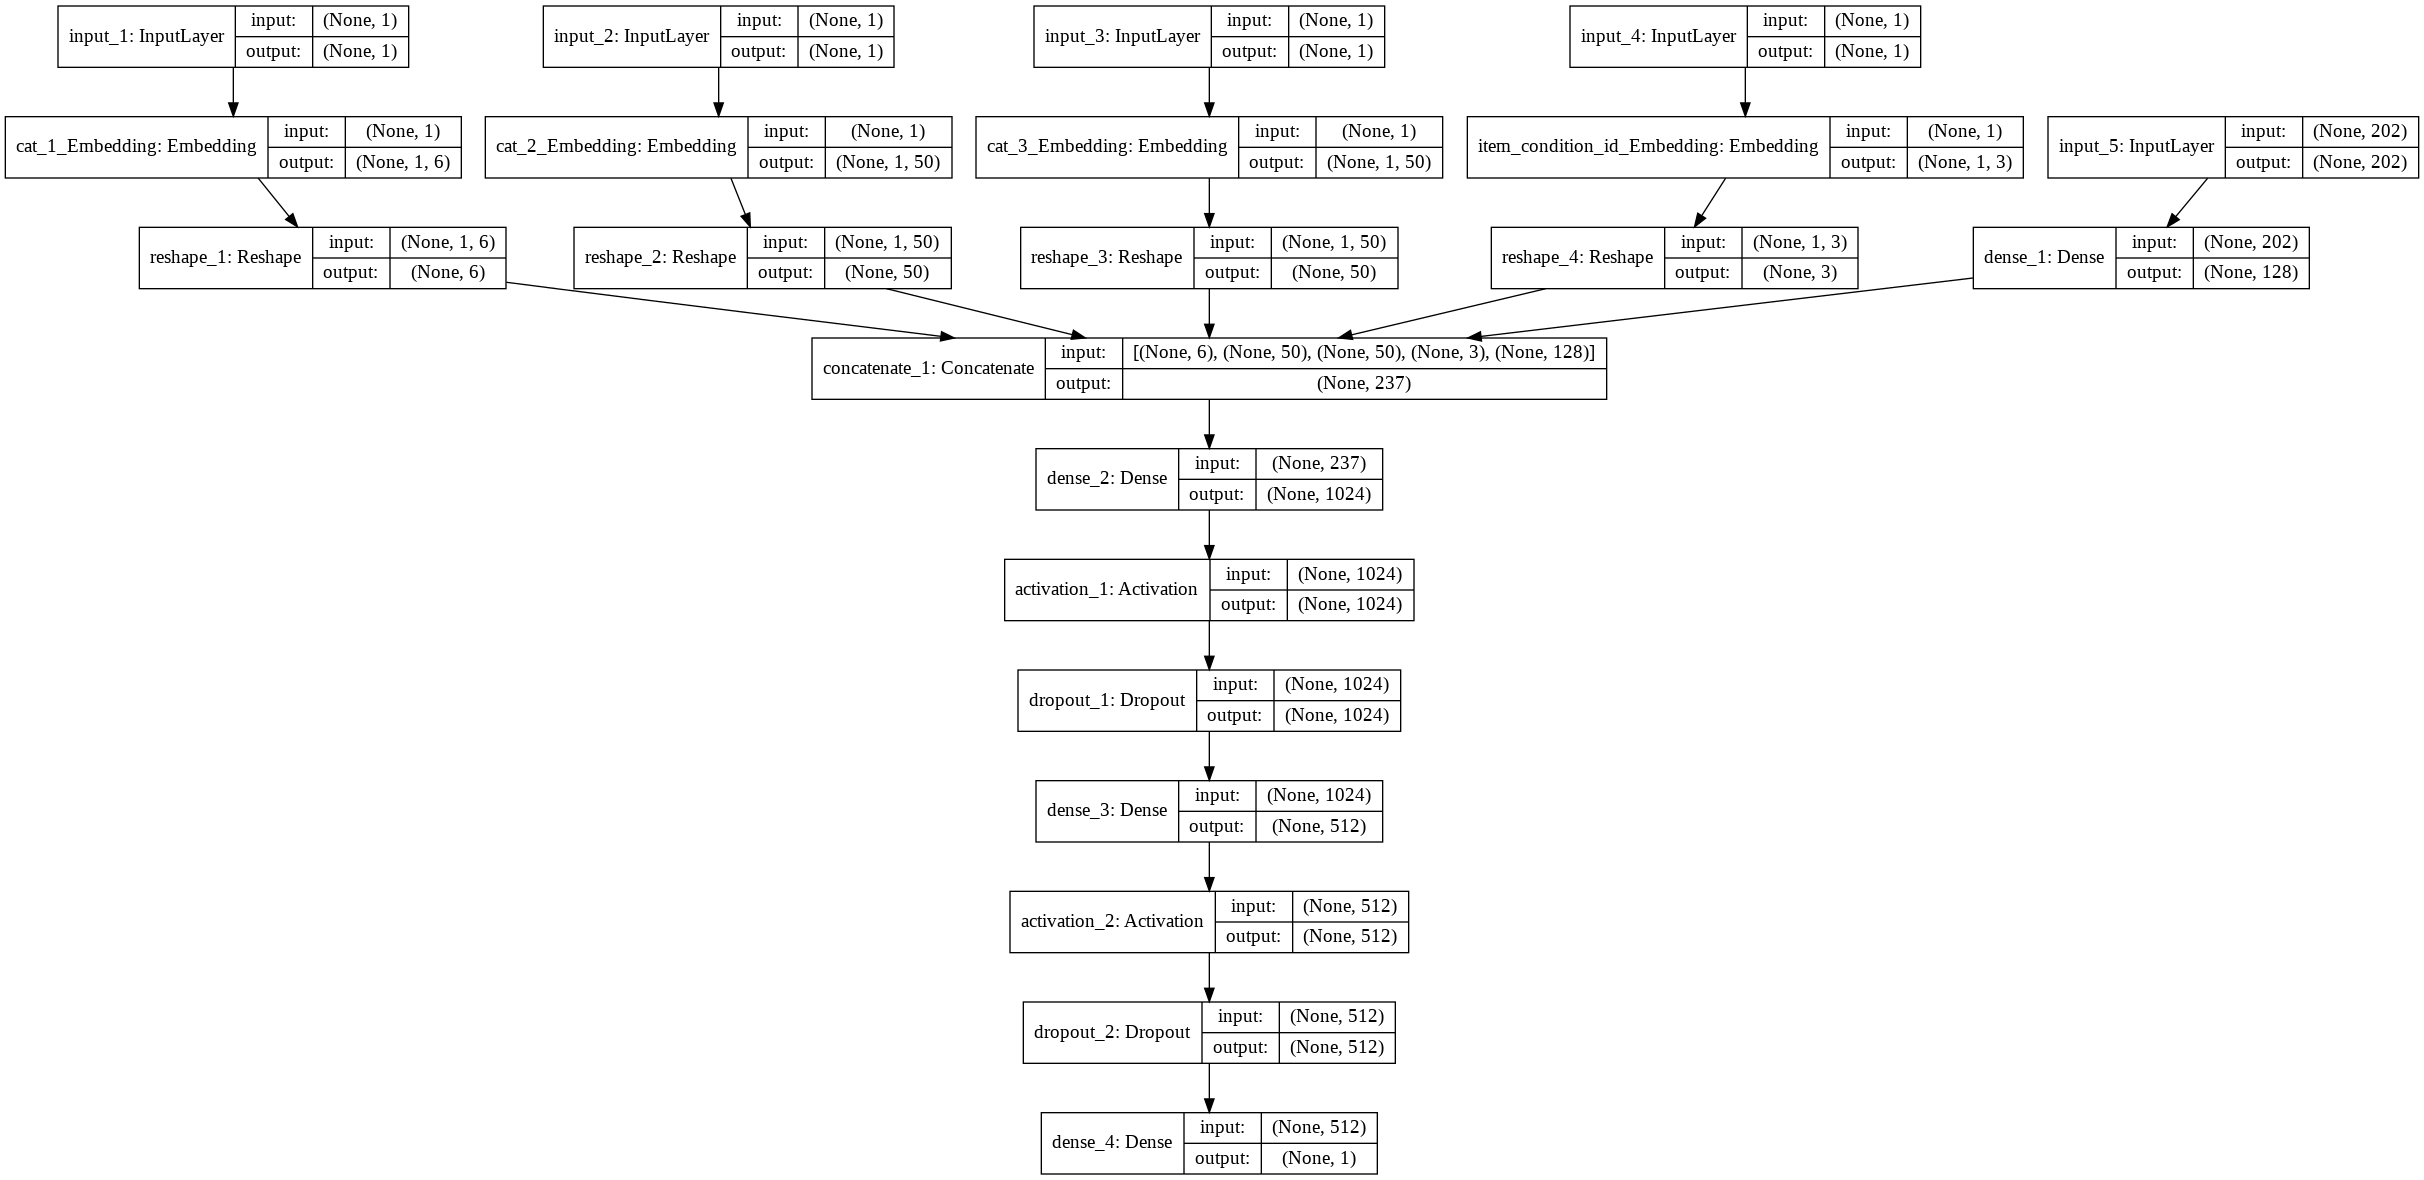

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file= input_folder + 'dumps/ee_dnn_model.png')
from IPython.display import Image
Image(retina=True, filename=input_folder + 'dumps/ee_dnn_model.png')

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
cat_1_Embe

### Training neural network

In [0]:
history = History()

callbacks = [history, 
             EarlyStopping(monitor='val_rmsle', patience=10, verbose=1, min_delta=1e-4, restore_best_weights=True, mode='min'),
             ReduceLROnPlateau(monitor='val_rmsle', factor=0.1, patience=7, cooldown=10, min_lr=1e-7, verbose=1, mode='min'),
             ModelCheckpoint(filepath=input_folder + 'model_word2vec.best.weights.hdf5', 
             monitor='val_rmsle', verbose=1, save_weights_only=True,  
             save_best_only=True, mode='min')]

In [0]:
X_train_list = preproc_generator(X_train, embed_val_map)
X_val_list = preproc_generator(X_val, embed_val_map)
X_test_list = preproc_generator(X_test, embed_val_map)

In [0]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs = 1200 , batch_size = 512, verbose= 1, callbacks=callbacks)

Train on 1333492 samples, validate on 74083 samples
Epoch 1/1200
1333492/1333492 [==============================] - 41s 31us/step - loss: 0.8995 - rmsle: 0.5230 - val_loss: 0.7688 - val_rmsle: 0.5071

Epoch 00001: val_rmsle improved from inf to 0.50708, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model_word2vec.best.weights.hdf5
Epoch 2/1200
1333492/1333492 [==============================] - 37s 28us/step - loss: 0.8278 - rmsle: 0.5061 - val_loss: 0.7593 - val_rmsle: 0.5025

Epoch 00002: val_rmsle improved from 0.50708 to 0.50253, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model_word2vec.best.weights.hdf5
Epoch 3/1200
1333492/1333492 [==============================] - 37s 28us/step - loss: 0.8205 - rmsle: 0.5031 - val_loss: 0.7495 - val_rmsle: 0.4976

Epoch 00003: val_rmsle improved from 0.50253 to 0.49758, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model_word2vec.best.weights.

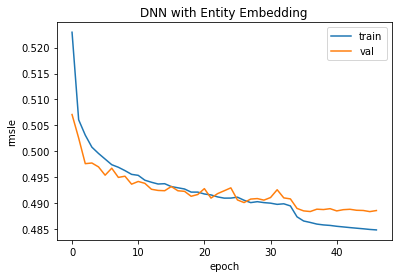

In [0]:
# summarize history for accuracy
plt.plot(history.history['rmsle'])
plt.plot(history.history['val_rmsle'])
plt.title('DNN with Entity Embedding')
plt.ylabel('rmsle')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
#List out Hyperparameters ???
history.history['val_rmsle'][-1]

0.48851542824000127

# 4. Data Modelling: XgBoost with Entity Embedding 

Run the above code atleast till the DNN model compilation cell.

In [0]:
model.load_weights(filepath=input_folder + 'model_word2vec.best.weights.hdf5')

After training of our model, a new category can come up in test set that was not previously in the train dataset. We need to handle that for XgBoost. In the DNN, we handled the same in the prepoc_generator function.

In [0]:
# This function compares the unique values in test data with that of train, and replaces any new unique value in the test set with UNK token.  
def mark_unseen_cat_as_unk(X_train, X_test):
  unk_in_embed = {'cat_1': 'unk_cat1', 'cat_2': 'unk_cat2', 'cat_3': 'unk_cat3', 'item_condition_id': 1}
  for c in embed_cols:
    for unk_cat in set(X_test[c].unique()).difference(set(X_train[c].unique())):
      X_test.loc[X_test[c] == unk_cat, c] = unk_in_embed[c]  
  return X_test

val_data = mark_unseen_cat_as_unk(train_data, val_data)
test_data = mark_unseen_cat_as_unk(train_data, test_data)

Extract the embedding layer weights from the trained DNN model. These embedding layer weights replace the categorical attribute with N-dim vectors that are able to capture richer & complex relationships between those categories that OHE can not. 

In [0]:
cat_1_Embedding = model.get_layer('cat_1_Embedding').get_weights()[0]
cat_2_Embedding = model.get_layer('cat_2_Embedding').get_weights()[0]
cat_3_Embedding = model.get_layer('cat_3_Embedding').get_weights()[0]
item_condition_id_Embedding  = model.get_layer('item_condition_id_Embedding').get_weights()[0]

**Now, we will replace each value of categorical attribute columns with their learnt embedding vectors.**

In [0]:
embed_map = {'cat_1': cat_1_Embedding, 'cat_2': cat_2_Embedding, 'cat_3': cat_3_Embedding, 'item_condition_id': item_condition_id_Embedding}

In [0]:
embed_val_map = {}
for c in embed_cols:
        raw_vals = np.unique(train_data[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = embed_map[c][i]
        embed_val_map[c] = val_map

In [0]:
train_data = pd.concat((train_data, 
                        train_data.apply(lambda x: embed_val_map['cat_1'][x['cat_1']], axis=1, result_type='expand'), 
                        train_data.apply(lambda x: embed_val_map['cat_2'][x['cat_2']], axis=1, result_type='expand'),
                        train_data.apply(lambda x: embed_val_map['cat_3'][x['cat_3']], axis=1, result_type='expand'),
                        train_data.apply(lambda x: embed_val_map['item_condition_id'][x['item_condition_id']], axis=1, result_type='expand')),
                        axis=1)

In [0]:
val_data = pd.concat((val_data, 
                        val_data.apply(lambda x: embed_val_map['cat_1'][x['cat_1']], axis=1, result_type='expand'), 
                        val_data.apply(lambda x: embed_val_map['cat_2'][x['cat_2']], axis=1, result_type='expand'),
                        val_data.apply(lambda x: embed_val_map['cat_3'][x['cat_3']], axis=1, result_type='expand'),
                        val_data.apply(lambda x: embed_val_map['item_condition_id'][x['item_condition_id']], axis=1, result_type='expand')),
                        axis=1)

In [0]:
test_data = pd.concat((test_data, 
                        test_data.apply(lambda x: embed_val_map['cat_1'][x['cat_1']], axis=1, result_type='expand'), 
                        test_data.apply(lambda x: embed_val_map['cat_2'][x['cat_2']], axis=1, result_type='expand'),
                        test_data.apply(lambda x: embed_val_map['cat_3'][x['cat_3']], axis=1, result_type='expand'),
                        test_data.apply(lambda x: embed_val_map['item_condition_id'][x['item_condition_id']], axis=1, result_type='expand')),
                        axis=1)

Now, the embedding vectors have been added to the dataset. We rename some of the duplicate columns that were formed in the previous steps.

In [0]:
import xgboost as xgb

In [0]:
cols = pd.io.parsers.ParserBase({'names':train_data.columns})._maybe_dedup_names(train_data.columns)
train_data.columns = cols
val_data.columns = cols
test_data.columns = cols
train_data.drop(labels=['train_id', 'cat_1', 'cat_2', 'cat_3', 'item_condition_id', 'category_name'], axis=1, inplace=True)
val_data.drop(labels=['train_id', 'cat_1', 'cat_2', 'cat_3', 'item_condition_id', 'category_name'], axis=1, inplace=True)
test_data.drop(labels=['train_id', 'cat_1', 'cat_2', 'cat_3', 'item_condition_id', 'category_name'], axis=1, inplace=True)

In [0]:
train_data.to_pickle(input_folder + 'train_xgboost.pkl')
val_data.to_pickle(input_folder + 'val_xgboost.pkl')
test_data.to_pickle(input_folder + 'test_xgboost.pkl')

In [0]:
# Selection of features
xg_train_ft = train_data.columns.to_list()
xg_train_ft.remove('price')

xg_target = 'price'

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = train_data[xg_train_ft], val_data[xg_train_ft], test_data[xg_train_ft], train_data[xg_target], val_data[xg_target], test_data[xg_target]

In [0]:
# Redefine RMSLE function in NumPy
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [0]:
# Train the XgBoost Regressor using GPU
regressor = xgb.XGBRegressor(**{"updater": "grow_gpu_hist"})
regressor.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:05:51] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[14:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, updater='grow_gpu_hist', verbosity=1)

In [0]:
y_pred = regressor.predict(X_test)

In [0]:
print('The RMSL of XgBoost on test set is:', rmsle(y_test.values, y_pred))

The RMSL of XgBoost on test set is: 0.4303965569919772
